In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances_argmin
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import seaborn as sns

In [28]:
wine = load_wine(as_frame=True)
X = wine.data  # 13 variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Silhouette: 0.285
Davies‑Bouldin: 1.389
Calinski‑Harabasz: 70.9


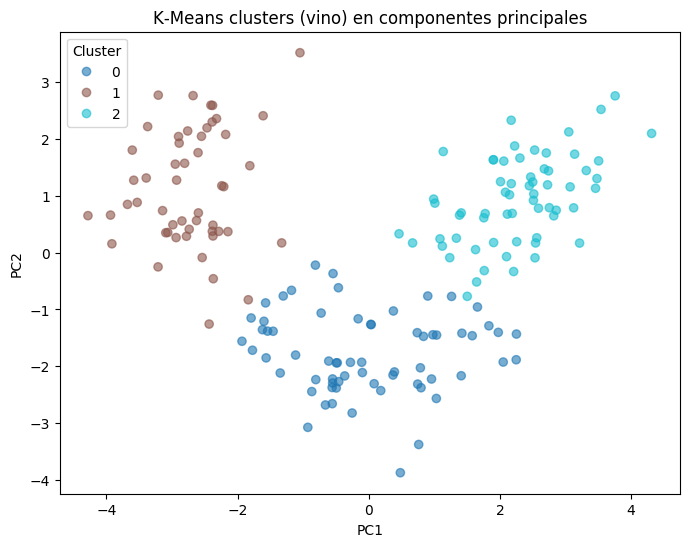

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
labels = kmeans.fit_predict(X_scaled)

sil_score = silhouette_score(X_scaled, labels)
db_score  = davies_bouldin_score(X_scaled, labels)
ch_score  = calinski_harabasz_score(X_scaled, labels)

print(f"Silhouette: {sil_score:.3f}")
print(f"Davies‑Bouldin: {db_score:.3f}")
print(f"Calinski‑Harabasz: {ch_score:.1f}")

# Vizualizar
pca = PCA(n_components=2)
X2 = pca.fit_transform(X_scaled)

df = pd.DataFrame({
    'PC1': X2[:,0],
    'PC2': X2[:,1],
    'Cluster': labels.astype(str),
    'TrueLabel': wine.target.astype(str)
})

plt.figure(figsize=(8,6))
scatter = plt.scatter(df.PC1, df.PC2, c=df.Cluster.astype(int), cmap='tab10', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.title("K‑Means clusters (vino) en componentes principales")
plt.xlabel("PC1"), plt.ylabel("PC2")
plt.show()


## DB-Scan

100%|██████████| 100/100 [00:01<00:00, 93.12trial/s, best loss: -0.20438854495188732]


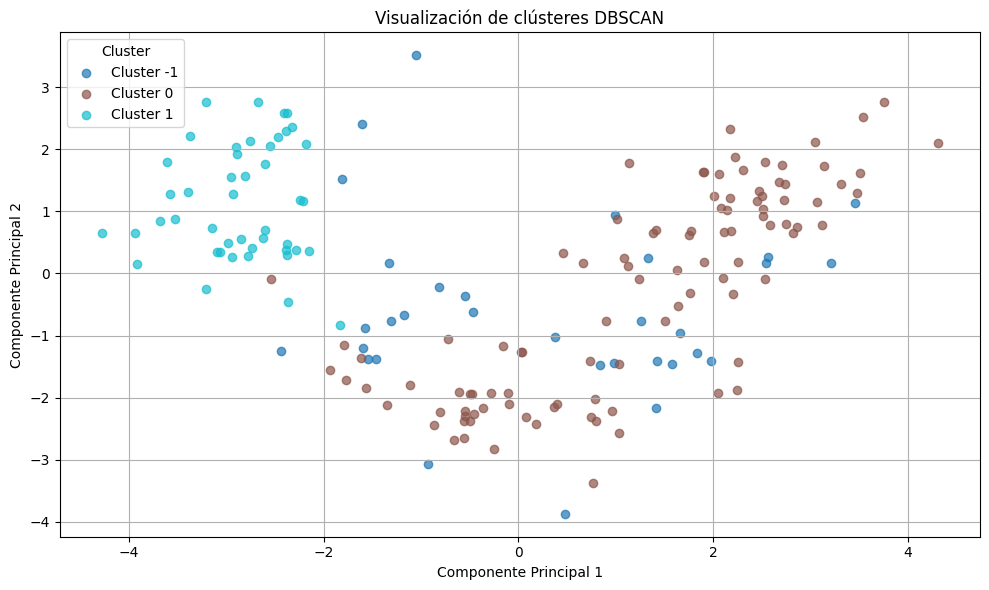

In [38]:
space = {
    'eps': hp.uniform('eps', 0.1, 2.5),
    'min_samples': hp.quniform('min_samples', 3, 11, 1)
}


def objective(params):
    clustering = DBSCAN(
        eps=params['eps'],
        min_samples=int(params['min_samples'])
      )
    labels = clustering.fit_predict(X_scaled)

    # Penalizar si hay un solo grupo o todos son ruido
    if len(set(labels)) <= 1 or set(labels) == {-1}:
        return 1.0

    score = silhouette_score(X_scaled, labels)
    return -score

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# Entrenar DBSCAN con los mejores hiperparámetros
best_eps = best['eps']
best_min_samples = int(best['min_samples'])

final_model = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels = final_model.fit_predict(X_scaled)

#  DataFrame con los datos originales y sus etiquetas
result_df = wine.data.copy()
result_df['cluster'] = labels

# Visualización de los clústeres
X_pca = PCA(n_components=2).fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(labels))))

for i, cluster_label in enumerate(np.unique(labels)):
    cluster_mask = labels == cluster_label
    plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1],
                label=f"Cluster {cluster_label}", alpha=0.7, color=colors[i])

plt.title("Visualización de clústeres DBSCAN")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

## BFR (Bradley-Fayyad-Reina)



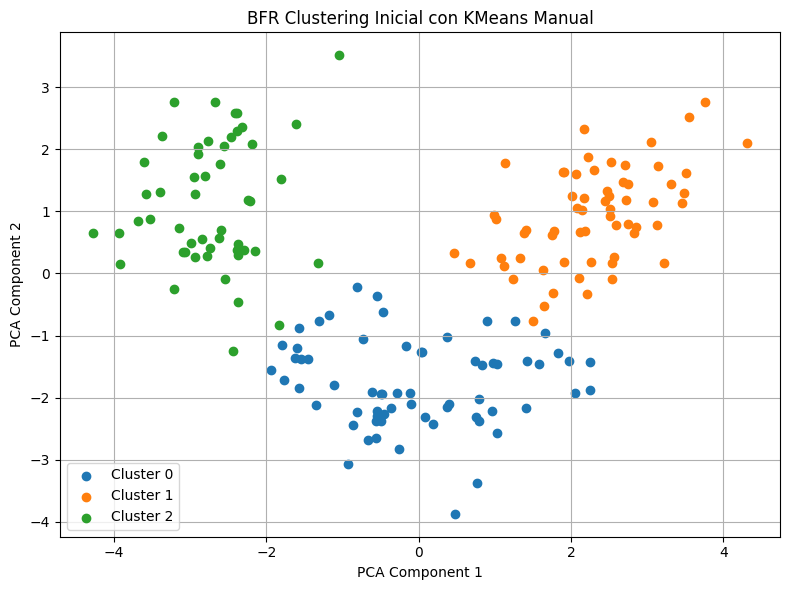

Cluster 0: N = 65, Media = [-0.93 -0.39 -0.49  0.17 -0.49 -0.08  0.02 -0.03  0.06 -0.9   0.46  0.27
 -0.75]
Cluster 1: N = 62, Media = [ 0.84 -0.3   0.36 -0.61  0.58  0.89  0.98 -0.56  0.58  0.17  0.47  0.78
  1.13]
Cluster 2: N = 51, Media = [ 0.16  0.87  0.19  0.52 -0.08 -0.98 -1.22  0.73 -0.78  0.94 -1.16 -1.29
 -0.41]


In [46]:
def manual_kmeans(X, k, max_iters=100):
    np.random.seed(42)
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]

    for _ in range(max_iters):
        labels = pairwise_distances_argmin(X, centroids)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return centroids, labels

k = 3  # número de clusters deseado
centroids, labels = manual_kmeans(X_scaled, k)
DS = {i: {
    'N': 0, 'SUM': np.zeros(X.shape[1]),
    'SUMSQ': np.zeros(X.shape[1])} for i in range(k)
}

for i, x in enumerate(X_scaled):
    cluster = labels[i]
    DS[cluster]['N'] += 1
    DS[cluster]['SUM'] += x
    DS[cluster]['SUMSQ'] += x ** 2

# Vizulizar con PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for cluster_id in range(k):
    mask = labels == cluster_id
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], label=f"Cluster {cluster_id}")

plt.title("BFR Clustering Inicial con KMeans Manual")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Estadostocas de cada cuso
for cluster_id, stats in DS.items():
    media = stats['SUM'] / stats['N'] if stats['N'] > 0 else np.zeros(X.shape[1])
    print(f"Cluster {cluster_id}: N = {stats['N']}, Media = {media.round(2)}")

**Silhouette Score** sería mi métrica principal porque:

* **Cohesión vs separación**: combina la distancia media intra‑cluster (qué tan juntos están los puntos) y la distancia media al siguiente cluster más cercano (qué tan separados están) en un solo valor $\in[-1,1]$.
* **Sin etiquetas**: funciona en clustering no supervisado, no requiere “ground truth”.
* **Guía de parámetros**: al buscar $\theta$ o el número de micro‑clusters en BFR, maximizar la Silhouette te lleva a configuraciones con clusters bien definidos.

Como complemento rápido, usaría **Davies–Bouldin** (menor es mejor) o **Calinski–Harabasz** (mayor es mejor) para contrastar, pero la Silhouette te da la visión más directa y fácil de interpretar.
